<a href="https://colab.research.google.com/github/astrodeepnet/sbi_experiments/blob/ramp_bijector/notebooks/score_matching/NF_implicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nomalizing Flow with implicit coupling layers


In [1]:
!pip install --quiet --upgrade dm-haiku optax tensorflow-probability
!pip install --quiet git+https://github.com/astrodeepnet/sbi_experiments.git@ramp_bijector

     |████████████████████████████████| 287 kB 6.8 MB/s 
     |████████████████████████████████| 126 kB 66.6 MB/s 
     |████████████████████████████████| 65 kB 4.8 MB/s 


In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as onp
import haiku as hk
import optax
from functools import partial
from tqdm import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

Populating the interactive namespace from numpy and matplotlib


In [346]:
d=2
batch_size = 1024

In [347]:
from sbiexpt.distributions import get_two_moons
from sbiexpt.bijectors import ImplicitRampBijector, MixtureImplicitRampBijector

In [379]:
@jax.jit
def get_batch(seed):
  two_moons = get_two_moons(sigma = 0.01, normalized=True)
  #seed = jax.random.PRNGKey(0)
  batch = two_moons.sample(batch_size, seed=seed)
  score = jax.vmap(jax.grad(two_moons.log_prob))(batch)
  return batch, score

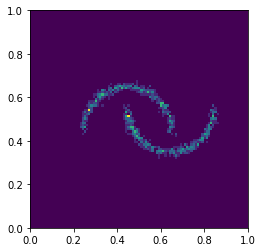

In [380]:
batch, score = get_batch(jax.random.PRNGKey(0))
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]); gca().set_aspect('equal');

In [449]:
class CustomCoupling(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __call__(self, x, output_units, **condition_kwargs):

    n_mixtures = 8
    # NN to get a b and c
    net = hk.Linear(256, name='layer1')(x)
    net = jnp.sin(net)
    net = hk.Linear(256, name='layer2')(net)
    net = jnp.sin(net)
#     net = hk.Linear(256)(net)
#     net = jnp.sin(net)
    
    log_a_bound=4
    min_density_lower_bound=1e-4
    
    log_a = jax.nn.tanh(hk.Linear(output_units*n_mixtures, name='layer3')(net)) * log_a_bound
    b   = jax.nn.sigmoid(hk.Linear(output_units*n_mixtures, name='layer4')(net))
    c   = min_density_lower_bound + jax.nn.sigmoid(hk.Linear(output_units*n_mixtures, name='layer5')(net)) * (1 - min_density_lower_bound)
    p = jax.nn.softmax(hk.Linear(n_mixtures, name='layer6')(net))
    
    return MixtureImplicitRampBijector(lambda x: x**3, 
                                       jnp.exp(log_a).reshape([-1,n_mixtures,output_units]),
                                       b.reshape([-1,n_mixtures,output_units]),
                                       c.reshape([-1,n_mixtures,output_units]),
                                       p)

class Flow(hk.Module):
    """A normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
      chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b1')),
            tfb.Permute([1,0]),
            tfb.RealNVP(d//2, bijector_fn=CustomCoupling(name = 'b2')),
        ])
      
      nvp = tfd.TransformedDistribution(
            tfd.Independent(tfd.TruncatedNormal(0.5*jnp.ones(d), 
                                                0.2*jnp.ones(d), 
                                                0.001,0.999),
                            reinterpreted_batch_ndims=1),
            bijector=chain)
        
      return nvp

In [450]:
model_NF = hk.without_apply_rng(hk.transform(lambda x : Flow()().log_prob(x)))
model_jac = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse_log_det_jacobian(x)))
model_inv = hk.without_apply_rng(hk.transform(lambda x : Flow()().bijector.inverse(x)))
model_sample = hk.without_apply_rng(hk.transform(lambda : Flow()().sample(1024, seed=next(rng_seq))))

In [451]:
rng_seq = hk.PRNGSequence(12)
params = model_NF.init(next(rng_seq), jnp.zeros([batch_size,d]))

In [452]:
# # TO DO
#@jax.jit
def loss1_fn(params, batch, score):
  log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  return -jnp.mean(log_prob)

# @jax.jit
# def loss_fn(params, batch, score):
#   out = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
#   return jnp.mean( jnp.sum((out - score)**2, axis=1))

#@jax.jit
def loss2_fn(params, batch, score):
#   log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
  return -jnp.mean(log_prob) # jnp.mean( jnp.sum((out - score)**2, axis=1))/1000jax.value_and_grad

In [453]:
g1 = jax.grad(lambda p:loss1_fn(p, batch, score))(params)

In [454]:
g2 = jax.grad(lambda p:loss2_fn(p, batch, score))(params)

In [455]:
g1['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[-0.00658317, -0.01149605,  0.03822916, -0.03313291,
               0.00580889, -0.02379039, -0.0238911 , -0.0237825 ,
              -0.02729555,  0.00238617]], dtype=float32)

In [456]:
g2['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[-0.00658317, -0.01149605,  0.03822916, -0.03313291,
               0.00580889, -0.02379039, -0.0238911 , -0.0237825 ,
              -0.02729555,  0.00238617]], dtype=float32)

In [457]:
params['flow/b1/layer1']['w'][:10,:10]

DeviceArray([[ 0.18158716,  0.6225872 ,  0.91571075,  1.6014925 ,
              -1.440559  , -0.6829792 ,  0.54838717,  0.1963539 ,
               0.06737389,  1.3469422 ]], dtype=float32)

In [313]:
params.keys()

KeysOnlyKeysView(['flow/b1/layer1', 'flow/b1/layer2', 'flow/b1/layer3', 'flow/b1/layer4', 'flow/b1/layer5', 'flow/b2/layer1', 'flow/b2/layer2', 'flow/b2/layer3', 'flow/b2/layer4', 'flow/b2/layer5'])

In [223]:
loss2_fn(params, batch, score)

logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


DeviceArray(3.9709241, dtype=float32)

In [215]:
mat2 = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([-1,2])).squeeze()))(batch)

logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (1, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


In [216]:
mat2[20]

DeviceArray([ 16.442192, 179.46208 ], dtype=float32)

In [217]:
mat = jax.jacobian(lambda x: model_NF.apply(params, x))(batch)

logdet (64, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)
logdet (64, 1)
inner logdet (1,) (8, 1) (8, 1) (8, 1) (8,)


In [218]:
mat[20,20]

DeviceArray([ 16.441887, 179.46158 ], dtype=float32)

In [458]:
#@jax.jit
def loss_fn(params, batch, score):
  log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  return -jnp.mean(log_prob)

In [331]:
def loss_fn(params, batch, score):
#   log_prob = jax.vmap((lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch)
  log_prob, out = jax.vmap(jax.value_and_grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
  return -jnp.mean(log_prob) + jnp.mean( jnp.sum((out - score)**2, axis=1))/1000.

In [354]:
@jax.jit
def loss_fn(params, batch, score):
  out = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(batch) # Here we extract the grad of the model
  return jnp.mean( jnp.sum((out - score)**2, axis=1))/1000.0

In [459]:
learning_rate=0.001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [460]:
@jax.jit
def update(params, opt_state, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [461]:
losses = []
master_seed = hk.PRNGSequence(0)

In [462]:
for step in tqdm(range(5000)):
    batch, score = get_batch(next(master_seed))
    l, params, opt_state = update(params, opt_state, batch, score)
    losses.append(l)

100%|██████████| 5000/5000 [02:39<00:00, 31.43it/s] 


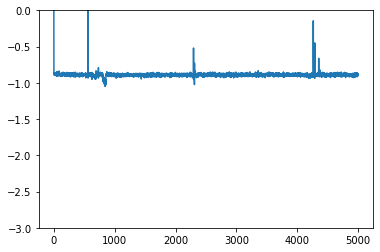

In [463]:
ylim(-3,0)
plot(losses[:])

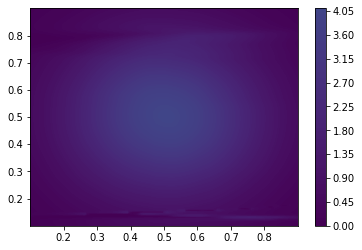

In [464]:
# with gradients
x = (jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,128),
                           jnp.linspace(0.1,0.9,128)),-1) )

im = model_NF.apply(params, x.reshape(-1,2)).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im),100,vmax=20); colorbar()
#scatter(batch[:,0],batch[:,1],marker='+',color='r',alpha=0.25)

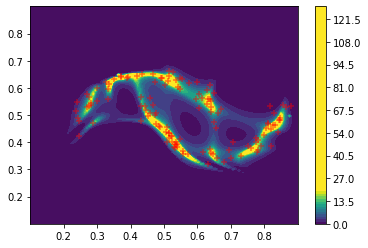

In [464]:
# without gradients
x = (jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,128),
                           jnp.linspace(0.1,0.9,128)),-1) )

im = model_NF.apply(params, x.reshape(-1,2)).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im),100,vmax=20); colorbar()
scatter(batch[:,0],batch[:,1],marker='+',color='r',alpha=0.5)

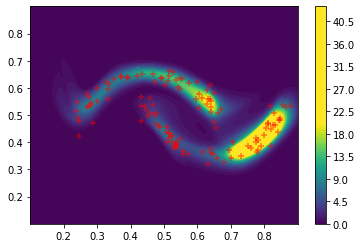

In [455]:
# with gradient
x = (jnp.stack(jnp.meshgrid(jnp.linspace(0.1,0.9,128),
                           jnp.linspace(0.1,0.9,128)),-1) )

im = model_NF.apply(params, x.reshape(-1,2)).reshape([128,128])
contourf(x[...,0],x[...,1],jnp.exp(im),100,vmax=20); colorbar()
scatter(batch[:,0],batch[:,1],marker='+',color='r',alpha=0.5)

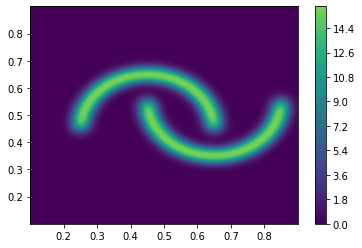

In [425]:
contourf(x[...,0],x[...,1],get_two_moons(sigma= 0.02, normalized=True).prob(x),100,vmax=20); colorbar()

In [91]:
X = np.arange(-1.5, 2.5, 0.1) / 5 + 0.45
Y = np.arange(-1, 1.5, 0.1) / 5 + 0.45
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2)) 

# Getting value of the log prob and score for the true distribution
logp = get_two_moons(sigma=0.01, normalized=True).prob(points).reshape([len(Y), len(X)])
true_score = jax.vmap(jax.grad(lambda x: get_two_moons(sigma=0.01, normalized=True).log_prob(x)))(points).reshape([len(Y), len(X), 2])

# Getting value of the score as predicted by the NN
pred_fn = model_NF.apply(params, points).reshape([len(Y), len(X)])
pred_score = jax.vmap(jax.grad(lambda x: model_NF.apply(params, x.reshape([1,2])).squeeze()))(points).reshape([len(Y), len(X),2])

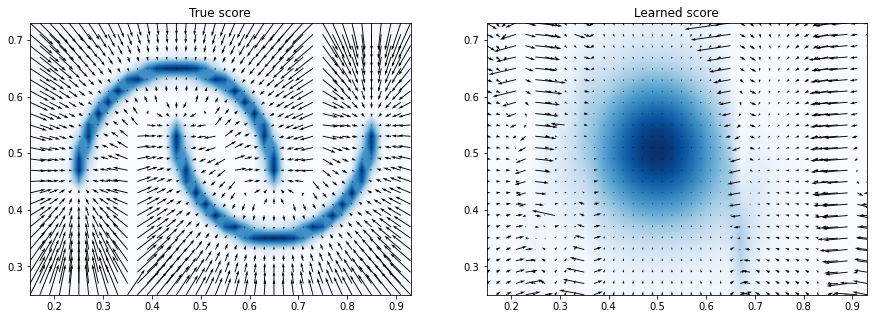

In [92]:
figure(figsize=[15,5])
subplot(121)
contourf(X,Y,logp, 256, cmap='Blues')
quiver(X, Y, true_score[:,:,0], true_score[:,:,1], scale=25000);
title('True score')

subplot(122)
contourf(X,Y,exp(pred_fn), 256, cmap='Blues')
quiver(X, Y, pred_score[:,:,0], pred_score[:,:,1]);
title('Learned score');

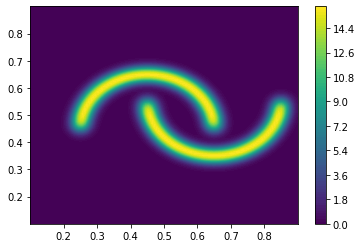

In [428]:
contourf(x[...,0],x[...,1],get_two_moons(sigma= 0.02, normalized=True).prob(x),100); colorbar()

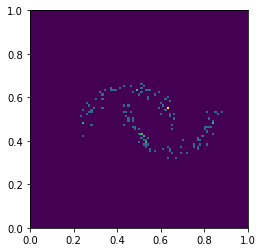

In [429]:
hist2d(batch[:,0], batch[:,1],100, range=[[0,1],[0,1]]);gca().set_aspect('equal');

In [430]:
x = model_inv.apply(params, batch)

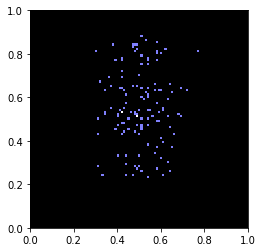

In [431]:
hist2d(x[:,0], x[:,1],100, range=[[0,1],[0,1]],cmap='gist_stern');gca().set_aspect('equal');

In [432]:
x = model_sample.apply(params)

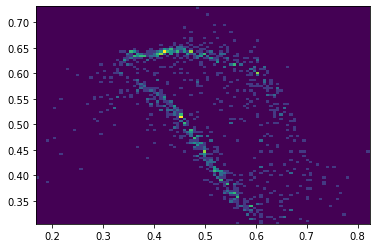

In [433]:
hist2d(x[:,0], x[:,1],100);gca().set_aspect('equal');

In [35]:
coupl = hk.without_apply_rng(hk.transform(lambda x: CustomCoupling(name = 'b2')(x,1)))

In [36]:
predicate = lambda module_name, name, value: 'flow/b2' in module_name
params_b1 = hk.data_structures.filter(predicate, params) 

In [37]:
params_b1=hk.data_structures.to_mutable_dict(params_b1)
params_b1={k.split('flow/')[1]:params_b1[k] for k in params_b1.keys()}

In [38]:
t = jnp.linspace(0,1)
bij = coupl.apply(params_b1, t.reshape([50,1]))

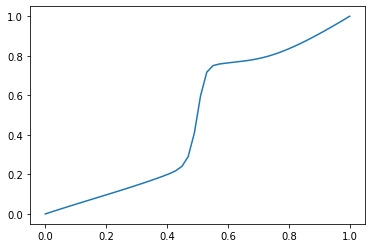

In [48]:
plot(t,bij(t.reshape([50,1])))

In [49]:
bij(t.reshape([50,1]))

DeviceArray([[0.        ],
             [0.01015936],
             [0.02022752],
             [0.03020584],
             [0.04009787],
             [0.04991021],
             [0.05965327],
             [0.06934179],
             [0.07899497],
             [0.0886365 ],
             [0.09829401],
             [0.10799856],
             [0.11778357],
             [0.12768368],
             [0.13773343],
             [0.14796622],
             [0.15841366],
             [0.16910878],
             [0.18010096],
             [0.19151524],
             [0.2037675 ],
             [0.21835126],
             [0.24069925],
             [0.2895041 ],
             [0.40956998],
             [0.59829265],
             [0.7168772 ],
             [0.75020826],
             [0.7582291 ],
             [0.76243484],
             [0.76620203],
             [0.76980543],
             [0.77357256],
             [0.7780105 ],
             [0.783566  ],
             [0.79051256],
             [0.79895306],
 

In [45]:
inv = bij.inverse(1*bij(t))

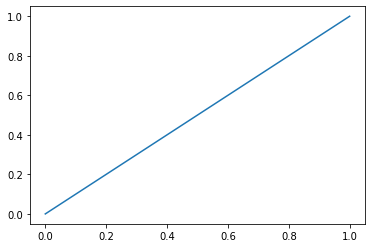

In [47]:
plot(t,inv)

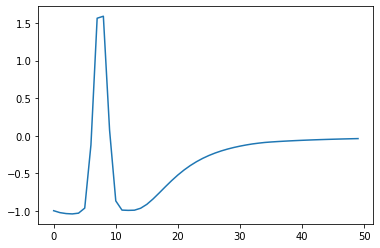

In [29]:
plot(bij.forward_log_det_jacobian(t.reshape([50,1])))

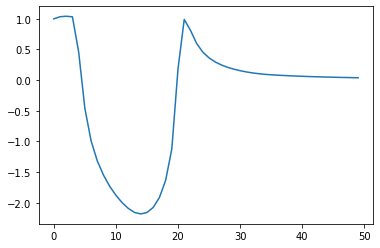

In [30]:
plot(bij.inverse_log_det_jacobian(t.reshape([50,1])))